In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import random
import math
import sys
import numpy as np
%matplotlib inline

In [2]:
# Parametros 
TAMANHO_DO_PLANO = 10000
QUANT_OBSTACULOS = 1000
RAIO = 100

PONTO_INICIO = (0,0)
PONTO_FIM = (TAMANHO_DO_PLANO,TAMANHO_DO_PLANO)

mapa_obstaculos = []
arestas_globais = []


In [3]:
def encerrar_com_mensagem(ax,mensagem, cor='red'):
    ax.text(0.5, 0.5, mensagem, ha='center', va='center', fontsize=16, color=cor, transform=ax.transAxes)
    plt.draw()
    plt.show(block=True)
    sys.exit()



In [4]:
def calcular_distancia(ponto1, ponto2): 
    return math.sqrt((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2) #  é a formula Euclidiana basicamente,  melhor forma pelo que eu vi ( a outra que eu tenti ainda tinha sobreposição na diagonal )



In [5]:
def verifica_intervalo(ponto_inserido,ponto_verifica):
    distancia = calcular_distancia(ponto_inserido,ponto_verifica)
    return ((distancia > (RAIO * 2)) | (distancia < 0))



In [6]:
def calcular_laterais(ponto_centro):
    ponto_cima = (ponto_centro[0] + RAIO,ponto_centro[1])
    ponto_baixo = (ponto_centro[0] - RAIO,ponto_centro[1])
    ponto_direito = (ponto_centro[0] ,ponto_centro[1] + RAIO)
    ponto_esquerdo = (ponto_centro[0] ,ponto_centro[1] - RAIO)
    return  ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo



In [7]:
def calcular_distancia_reta(r_a, r_b, r_c, c_x, c_y):
    cima = abs((r_a * c_x) + (r_b * c_y) + r_c)
    baixo = math.sqrt((r_a ** 2) + (r_b ** 2))
    return cima / baixo




In [8]:
def gerar_obstaculo_existente(novo_centro):
    if calcular_distancia(novo_centro, PONTO_INICIO) < RAIO:
        return True
    if calcular_distancia(novo_centro, PONTO_FIM) < RAIO:
        return True
    if any(not verifica_intervalo(novo_centro, obstaculo[0]) for obstaculo in mapa_obstaculos):
        return True
    return False



In [9]:
def posicionar_obstaculos():
    for _ in range(QUANT_OBSTACULOS):
        tentativas = 0
        while True:
            tentativas += 1
            if tentativas >= 1000:
                print(f"Não há mais espaço! Foram posicionados {len(mapa_obstaculos)} obstáculos.")
                return  # Sai do posicionamento, mas mantém os já posicionados
            x = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            y = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            novo_centro = (x, y)
            if gerar_obstaculo_existente(novo_centro):
                continue
            mapa_obstaculos.append((novo_centro, calcular_laterais(novo_centro)))
            break



In [10]:
def reta_livre_de_obstaculos(A, B, mapa_obstaculos, raio):
    for obstaculo in mapa_obstaculos:
        centro = obstaculo[0]
        laterais = obstaculo[1]
        
        # 1. Se A e B são laterais do mesmo círculo, bloqueia
        if A in laterais and B in laterais:
            return False
            
        # 2. Coeficientes da reta AB: ax + by + c = 0
        r_a = B[1] - A[1]
        r_b = A[0] - B[0] 
        r_c = B[1] * (B[0] - A[0]) - (B[1] - A[1]) * B[0]

        # 3. Distância do centro do círculo à reta
        dist_reta = calcular_distancia_reta(r_a, r_b, r_c, centro[0], centro[1])
        
        # 4. Se a distância for menor que o raio, há interseção
        if dist_reta < raio:
            # 5. Verifica se a interseção está no segmento AB (não na reta infinita)
            # Calcula o ponto mais próximo do centro na reta AB
            denominador = r_a * r_a + r_b * r_b
            if denominador != 0:
                px = (r_b * (r_b * centro[0] - r_a * centro[1]) - r_a * r_c) / denominador
                py = (r_a * (-r_b * centro[0] + r_a * centro[1]) - r_b * r_c) / denominador
                
                # Verifica se o ponto projetado está dentro do segmento AB
                min_x, max_x = min(A[0], B[0]), max(A[0], B[0])
                min_y, max_y = min(A[1], B[1]), max(A[1], B[1])
                
                if min_x <= px <= max_x and min_y <= py <= max_y:
                    return False
    return True



In [11]:
def gerar_arestas():
    # Gera todas as arestas válidas e as adiciona aos obstáculos
    # Formato: [ponto_centro, [pontos_laterais], [arestas]]
    
    # Primeiro, inicializa a lista de arestas para cada obstáculo
    for i, obstaculo in enumerate(mapa_obstaculos):
        if len(obstaculo) == 2:  # Se ainda não tem arestas
            mapa_obstaculos[i] = (obstaculo[0], obstaculo[1], [])
    
    # Arestas do início aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_INICIO, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_INICIO, ponto_lateral, 'blue', '--')
                arestas_globais.append(aresta)
    
    # Arestas do fim aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_FIM, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_FIM, ponto_lateral, 'red', '--')
                arestas_globais.append(aresta)
    
    # Arestas entre pontos laterais (evita duplicação)
    for i, obstaculo_a in enumerate(mapa_obstaculos):
        for j, obstaculo_b in enumerate(mapa_obstaculos):
            if i >= j:  # Evita duplicação (só processa i < j)
                continue
            for ponto_lateral_a in obstaculo_a[1]:
                for ponto_lateral_b in obstaculo_b[1]:
                    if reta_livre_de_obstaculos(ponto_lateral_a, ponto_lateral_b, mapa_obstaculos, RAIO):
                        aresta = (ponto_lateral_a, ponto_lateral_b, 'green', '-')
                        # Adiciona à lista do primeiro obstáculo
                        mapa_obstaculos[i] = (mapa_obstaculos[i][0], mapa_obstaculos[i][1], mapa_obstaculos[i][2] + [aresta])
    
    # Verifica caminho direto início-fim
    if reta_livre_de_obstaculos(PONTO_INICIO, PONTO_FIM, mapa_obstaculos, RAIO):
        aresta = (PONTO_INICIO, PONTO_FIM, 'purple', '-')
        arestas_globais.append(aresta)



In [12]:
def caminho_ini_fim():
    """
        Percorre o mapa de obstaculos entre os pontos dos obstaculos, mas caso não tenha obstaculos, faz a linha direta, utilizando o conceito de busca por profundidade    
    """
    
    if len(mapa_obstaculos) == 0:
        return [PONTO_INICIO, PONTO_FIM]
    
    # Implementação de busca por profundidade (DFS) para encontrar um caminho
    stack = [(PONTO_INICIO, [PONTO_INICIO])]
    visited = set()
    
    while stack:
        current, path = stack.pop()
        
        if current == PONTO_FIM:
            return path
        
        if current in visited:
            continue
        visited.add(current)
        
        # Adiciona vizinhos (pontos laterais dos obstáculos conectados)
        for obstaculo in mapa_obstaculos:
            for ponto_lateral in obstaculo[1]:
                if reta_livre_de_obstaculos(current, ponto_lateral, mapa_obstaculos, RAIO):
                    stack.append((ponto_lateral, path + [ponto_lateral]))
    
    return None  # Se não encontrar caminho




In [13]:
def inicializar_plot():
    fig, ax = plt.subplots()
    ax.set_xlim(0, TAMANHO_DO_PLANO)
    ax.set_ylim(0, TAMANHO_DO_PLANO)
    ax.set_aspect('equal')
    ax.grid(color='gray', linestyle='--', alpha=0.3)
    ax.axhline(0, color='white', linewidth=0.5)
    ax.axvline(0, color='white', linewidth=0.5)
    ax.plot(PONTO_INICIO[0], PONTO_INICIO[1], 'go', markersize=10, label='Início')
    ax.plot(PONTO_FIM[0], PONTO_FIM[1], 'ro', markersize=10, label='Fim')
    
    # Opção 2: Colocar fora da figura (à direita)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)
    plt.tight_layout()  # Ajusta automaticamente para não cortar
    
    return fig, ax


In [14]:
def plotar_arestas(ax):
    # Plota arestas globais (início/fim)
    for aresta in arestas_globais:
        ponto_a, ponto_b, cor, estilo = aresta
        ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                color=cor, linestyle=estilo)
    
    # Plota arestas dos obstáculos
    for obstaculo in mapa_obstaculos:
        if len(obstaculo) > 2:  # Se tem arestas
            for aresta in obstaculo[2]:
                ponto_a, ponto_b, cor, estilo = aresta
                ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                        color=cor, linestyle=estilo)

In [15]:
def plotar_obstaculos():
    # Inicializa o plot com início e fim
    _,ax = inicializar_plot()
    
    # Desenha todos os obstáculos
    for obstaculo in mapa_obstaculos:
        circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
        for ponto in obstaculo[1]:
            ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
        ax.add_patch(circulo)
    
    plotar_arestas(ax)
    
    plt.title('Mapa de Obstáculos')
    plt.show()



Posicionados 1000 obstáculos


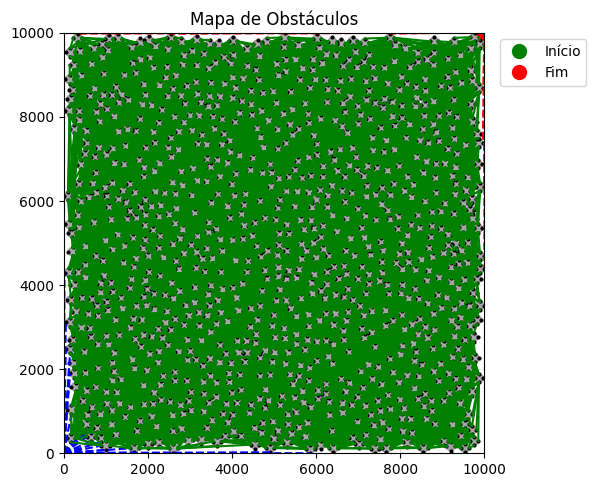

In [16]:
def main():
    posicionar_obstaculos()
    gerar_arestas()
    print(f"Posicionados {len(mapa_obstaculos)} obstáculos")
    plotar_obstaculos()

if __name__ == "__main__":
    main()

In [17]:
mapa_obstaculos[0]

((6412.465425155217, 121.18497471408449),
 ((6512.465425155217, 121.18497471408449),
  (6312.465425155217, 121.18497471408449),
  (6412.465425155217, 221.1849747140845),
  (6412.465425155217, 21.18497471408449)),
 [((6512.465425155217, 121.18497471408449),
   (6918.164240740014, 221.67010387261473),
   'green',
   '-'),
  ((6512.465425155217, 121.18497471408449),
   (7018.164240740014, 121.67010387261473),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (6918.164240740014, 221.67010387261473),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (6377.857365817732, 428.11045335797235),
   'green',
   '-'),
  ((6312.465425155217, 121.18497471408449),
   (5701.948270365242, 1105.2697579258684),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (5701.948270365242, 1105.2697579258684),
   'green',
   '-'),
  ((6512.465425155217, 121.18497471408449),
   (7079.395884726356, 1122.771471367194),
   'green',
   '-'),
  ((6412.465425155217, 221.1

In [31]:
mapa_obstaculos[0]

((6412.465425155217, 121.18497471408449),
 ((6512.465425155217, 121.18497471408449),
  (6312.465425155217, 121.18497471408449),
  (6412.465425155217, 221.1849747140845),
  (6412.465425155217, 21.18497471408449)),
 [((6512.465425155217, 121.18497471408449),
   (6918.164240740014, 221.67010387261473),
   'green',
   '-'),
  ((6512.465425155217, 121.18497471408449),
   (7018.164240740014, 121.67010387261473),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (6918.164240740014, 221.67010387261473),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (6377.857365817732, 428.11045335797235),
   'green',
   '-'),
  ((6312.465425155217, 121.18497471408449),
   (5701.948270365242, 1105.2697579258684),
   'green',
   '-'),
  ((6412.465425155217, 221.1849747140845),
   (5701.948270365242, 1105.2697579258684),
   'green',
   '-'),
  ((6512.465425155217, 121.18497471408449),
   (7079.395884726356, 1122.771471367194),
   'green',
   '-'),
  ((6412.465425155217, 221.1

In [32]:
arestas_globais

[((0, 0), (548.43182647212, 589.399136400359), 'blue', '--'),
 ((0, 0), (872.1876660976737, 823.0968368748552), 'blue', '--'),
 ((0, 0), (53.827310376810885, 3108.497943598396), 'blue', '--'),
 ((0, 0), (155.2597988306946, 1899.7082720305582), 'blue', '--'),
 ((0, 0), (4909.965526018762, 25.08320295393554), 'blue', '--'),
 ((0, 0), (21.714759665080777, 4296.048783988666), 'blue', '--'),
 ((0, 0), (892.5481084832563, 268.28814773673383), 'blue', '--'),
 ((0, 0), (553.442933144487, 388.54577586278145), 'blue', '--'),
 ((0, 0), (653.442933144487, 288.54577586278145), 'blue', '--'),
 ((0, 0), (139.21284632254606, 2145.3117704144242), 'blue', '--'),
 ((0, 0), (6.097816644349805, 6114.835388849743), 'blue', '--'),
 ((0, 0), (5866.012263596742, 1.4558026685097758), 'blue', '--'),
 ((0, 0), (2611.373560625171, 13.76548313765393), 'blue', '--'),
 ((0, 0), (74.89983069665641, 359.69451414961827), 'blue', '--'),
 ((0, 0), (174.8998306966564, 259.69451414961827), 'blue', '--'),
 ((0, 0), (898.6630

In [33]:
dict_caminhos = {}

# Inicializa todos os pontos laterais no dicionário
for obstaculo in mapa_obstaculos:
    for ponto_lateral in obstaculo[1]:
        dict_caminhos[ponto_lateral] = []

# Adiciona PONTO_INICIO e PONTO_FIM ao dicionário
dict_caminhos[PONTO_INICIO] = []
dict_caminhos[PONTO_FIM] = []

# Processa arestas dos obstáculos (conexões entre pontos laterais de obstáculos diferentes)
for obstaculo in mapa_obstaculos:
    if len(obstaculo) > 2:  # Se tem arestas
        for aresta in obstaculo[2]:
            ponto_a, ponto_b = aresta[0], aresta[1]
            # Adiciona conexão bidirecional
            if ponto_a in dict_caminhos:
                dict_caminhos[ponto_a].append(ponto_b)
            if ponto_b in dict_caminhos:
                dict_caminhos[ponto_b].append(ponto_a)

# Processa arestas globais (conexões com PONTO_INICIO e PONTO_FIM)
for aresta in arestas_globais:
    ponto_a, ponto_b = aresta[0], aresta[1]
    # Adiciona conexão bidirecional
    if ponto_a in dict_caminhos and ponto_b in dict_caminhos:
        dict_caminhos[ponto_a].append(ponto_b)
        dict_caminhos[ponto_b].append(ponto_a)


In [34]:
for obstaculo in mapa_obstaculos:
    ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo = obstaculo[1]
    dict_caminhos[ponto_direito].append(ponto_cima)
    dict_caminhos[ponto_cima].append(ponto_esquerdo)
    dict_caminhos[ponto_esquerdo].append(ponto_baixo)
    dict_caminhos[ponto_baixo].append(ponto_direito)

In [39]:
dict_caminhos

{(6512.465425155217,
  121.18497471408449): [(6918.164240740014,
   221.67010387261473), (7018.164240740014, 121.67010387261473), (7079.395884726356,
   1122.771471367194), (6524.924870426341,
   1185.7176719026097), (6848.582621341535, 1042.8275951644464), (7336.536404782712,
   1661.1776585216132), (6532.289674179112,
   966.066202100523), (6632.289674179112, 866.066202100523), (6883.012177639107,
   748.4631268623573), (6983.012177639107,
   648.4631268623573), (6778.12602736274, 365.3220327289363), (6878.12602736274,
   265.3220327289363), (7297.732511133859,
   111.17187579474302), (6412.465425155217, 21.18497471408449)],
 (6312.465425155217,
  121.18497471408449): [(5701.948270365242,
   1105.2697579258684), (5974.883042847809,
   1087.3652417647727), (5874.883042847809,
   987.3652417647727), (5832.224693387228,
   1624.5820020371648), (6146.899799170757,
   1293.6061650410327), (6046.899799170757,
   1193.6061650410327), (5899.342163150104,
   720.9235493537257), (6205.67726076

In [36]:
def encontrar_caminho_dfs(ponto_inicial, ponto_final):
    """
    Encontra um caminho usando busca em profundidade (DFS) com controle de visitados
    """
    stack = [(ponto_inicial, [ponto_inicial])]
    visited = set()
    
    while stack:
        current, path = stack.pop()
        
        if current == ponto_final:
            return path
        
        if current in visited:
            continue
        
        visited.add(current)
        
        # Adiciona vizinhos à pilha
        for neighbor in dict_caminhos.get(current, []):
            if neighbor not in visited:
                stack.append((neighbor, path + [neighbor]))
    
    return None

# Encontra o caminho
caminho_encontrado = encontrar_caminho_dfs(PONTO_INICIO, PONTO_FIM)
if caminho_encontrado:
    print(f"Caminho encontrado com {len(caminho_encontrado)} pontos:")
    for i, ponto in enumerate(caminho_encontrado):
        print(f"  {i}: {ponto}")
else:
    print("Nenhum caminho encontrado!")

Caminho encontrado com 1846 pontos:
  0: (0, 0)
  1: (1680.5341580392187, 19.117466005262855)
  2: (1580.5341580392187, 119.11746600526286)
  3: (1680.5341580392187, 219.11746600526286)
  4: (1780.5341580392187, 119.11746600526286)
  5: (2105.6535891662925, 772.5436425346015)
  6: (2005.6535891662925, 872.5436425346015)
  7: (2105.6535891662925, 972.5436425346015)
  8: (2205.6535891662925, 872.5436425346015)
  9: (2677.419293315298, 1140.4989656891403)
  10: (2777.419293315298, 1240.4989656891403)
  11: (2877.419293315298, 1140.4989656891403)
  12: (2777.419293315298, 1040.4989656891403)
  13: (1466.046309329109, 961.983780993745)
  14: (1566.046309329109, 861.983780993745)
  15: (1466.046309329109, 761.983780993745)
  16: (1366.046309329109, 861.983780993745)
  17: (795.0624211139191, 704.2637930390013)
  18: (895.0624211139191, 604.2637930390013)
  19: (795.0624211139191, 504.26379303900126)
  20: (695.0624211139191, 604.2637930390013)
  21: (174.8998306966564, 459.69451414961827)
  

In [37]:
def ponto_mesmo_centroide(ponto1, ponto2):
    for obstaculo in mapa_obstaculos:
        centro, laterais = obstaculo[0], obstaculo[1]
        if ponto1 in laterais and ponto2 in laterais:
            return True, centro
    return False, None


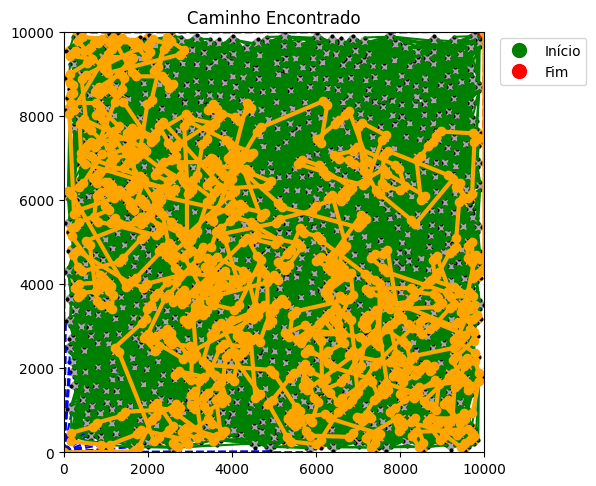

In [38]:
fig, ax = inicializar_plot()

# Plota obstáculos e arestas
for obstaculo in mapa_obstaculos:
    circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
    for ponto in obstaculo[1]:
        ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
    ax.add_patch(circulo)
plotar_arestas(ax)

# Plota o caminho encontrado
if caminho_encontrado:
    for i in range(len(caminho_encontrado) - 1):
        ponto1 = caminho_encontrado[i]
        ponto2 = caminho_encontrado[i + 1]
        
        mesmo_centro, centroid = ponto_mesmo_centroide(ponto1, ponto2)
        # print(mesmo_centro, centroid)
        if mesmo_centro:
            # Desenha arco entre pontos do mesmo obstáculo
            angulo1 = np.degrees(np.arctan2(ponto1[1] - centroid[1], ponto1[0] - centroid[0]))
            angulo2 = np.degrees(np.arctan2(ponto2[1] - centroid[1], ponto2[0] - centroid[0]))
            arco = Arc(centroid, width=2*RAIO, height=2*RAIO, theta1=angulo1, theta2=angulo2, color="orange", linewidth=2)
            ax.add_patch(arco)
        else:
            # Desenha linha reta entre pontos
            ax.plot([ponto1[0], ponto2[0]], [ponto1[1], ponto2[1]], 
                   color='orange', linewidth=3, marker='o')
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)

plt.title('Caminho Encontrado')
plt.show()
